In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from utils.utils import *
from utils.kabsch2D import *
from nsd_access import NSDAccess 
from scipy import stats
from utils.flips import create_rotation_df, get_ranking, get_rank_dict
from utils.stats import rank_correlation, parametric_test, wilcoxon_test

In [2]:
def all_subj_rank(dict, rois, random=True):
    """
    Take the dictionary containing the ranking for all participants and 
    return one final ranking, that is simply the sum of all rankings
    """
    if random:
        rank_total = np.zeros(len(rois) + 1)
    else:
        rank_total = np.zeros(len(rois))
    for i in range(len(dict)):
        rank_total += list(dict.values())[i]
    return rank_total

In [3]:
random = True
subj_list = [sub[0] for sub in list(subjects_sessions.values())]
subj_list

['subj01',
 'subj02',
 'subj03',
 'subj04',
 'subj05',
 'subj06',
 'subj07',
 'subj08']

In [4]:
subj_list = [sub[0] for sub in list(subjects_sessions.values())]
rank_dict, rank_dict_values = get_rank_dict(subj_list, rois, random=random, mode='averaged')

FileNotFoundError: [Errno 2] No such file or directory: '/media/Working/stan-thesis/projects/MDS/subj02/subj02_V1_mds_averaged.npy'

In [ ]:
rank_total = all_subj_rank(rank_dict_values, rois)
rank_total

In [1]:
rank_dict_values_norm = {key : (value - value.min()) / (value.max() - value.min()) for key, value in rank_dict_values.items()}
print(rank_dict_values_norm)
rank_total_norm = all_subj_rank(rank_dict_values_norm, rois)
rank_total_norm

NameError: name 'rank_dict_values' is not defined

## KENDALL TAU CORRELATION TEST

In [8]:
corr_df, corr_ps = rank_correlation(rank_dict)
corr_df

,subj01,subj02,subj03,subj04,subj05,subj06,subj07,subj08
subj01,1.000000,0.076923,0.205128,-0.153846,-0.128205,0.051282,0.743590,0.435897
subj02,0.076923,1.000000,0.153846,0.102564,0.435897,0.512821,0.076923,0.128205
subj03,0.205128,0.153846,1.000000,-0.025641,0.000000,-0.179487,0.205128,0.102564
subj04,-0.153846,0.102564,-0.025641,1.000000,0.102564,0.282051,-0.205128,-0.102564
subj05,-0.128205,0.435897,0.000000,0.102564,1.000000,0.307692,-0.128205,-0.076923
subj06,0.051282,0.512821,-0.179487,0.282051,0.307692,1.000000,-0.051282,0.256410
subj07,0.743590,0.076923,0.205128,-0.205128,-0.128205,-0.051282,1.000000,0.435897
subj08,0.435897,0.128205,0.102564,-0.102564,-0.076923,0.256410,0.435897,1.000000


In [9]:
corr_ps

,subj01,subj02,subj03,subj04,subj05,subj06,subj07,subj08
subj01,0.00000,0.76502,0.36740,0.50977,0.59004,0.85773,0.00015,0.04218
subj02,0.76502,0.00000,0.50977,0.67543,0.04218,0.01495,0.76502,0.59004
subj03,0.36740,0.50977,0.00000,0.95236,1.00000,0.43538,0.36740,0.67543
subj04,0.50977,0.67543,0.95236,0.00000,0.67543,0.20437,0.36740,0.67543
subj05,0.59004,0.04218,1.00000,0.67543,0.00000,0.16349,0.59004,0.76502
subj06,0.85773,0.01495,0.43538,0.20437,0.16349,0.00000,0.85773,0.25186
subj07,0.00015,0.76502,0.36740,0.36740,0.59004,0.85773,0.00000,0.04218
subj08,0.04218,0.59004,0.67543,0.67543,0.76502,0.25186,0.04218,0.00000


## PARAMETRIC TEST

In [11]:
parametric_test(subj_list, rois, iterations=100) # run for all participants, choose your iterations
# saved as a csv because it take ages to run 

KeyboardInterrupt: 

In [10]:
subj_01_param = os.path.join(param_dir, 'subj01_parametric_test_output.csv')
subj_01_param = pd.read_csv(subj_01_param)
subj_01_param

,V1,V2,V3,hV4,VO-1,VO-2,PHC-1,PHC-2,LO-1,LO-2,TO-1,TO-2
0,0.705701,0.693562,0.758649,0.695771,0.681423,0.685690,0.735221,0.707494,0.729752,0.727449,0.766598,0.727107
1,0.860689,0.863305,0.859996,0.869184,0.863800,0.870783,0.862977,0.868279,0.867184,0.866122,0.877780,0.865133
2,0.861478,0.862129,0.861776,0.870086,0.862865,0.870400,0.863960,0.867601,0.867113,0.865627,0.877274,0.865792
3,0.861181,0.862817,0.861719,0.868530,0.864568,0.870146,0.864130,0.867085,0.866388,0.866378,0.876999,0.864826
4,0.862330,0.862749,0.863022,0.869114,0.865014,0.871590,0.863237,0.866848,0.865667,0.866575,0.877271,0.866772
...,...,...,...,...,...,...,...,...,...,...,...,...
96,0.861872,0.861901,0.860442,0.868676,0.863903,0.869450,0.862284,0.867732,0.867689,0.864839,0.876246,0.866366
97,0.861733,0.862918,0.860718,0.869414,0.865307,0.869985,0.864077,0.867449,0.867545,0.867699,0.876563,0.867077
98,0.862114,0.862949,0.861889,0.869496,0.863813,0.870216,0.863545,0.867446,0.867465,0.866919,0.877127,0.865252
99,0.861501,0.863779,0.862356,0.869503,0.863793,0.870153,0.864325,0.868201,0.866810,0.866349,0.875614,0.866392


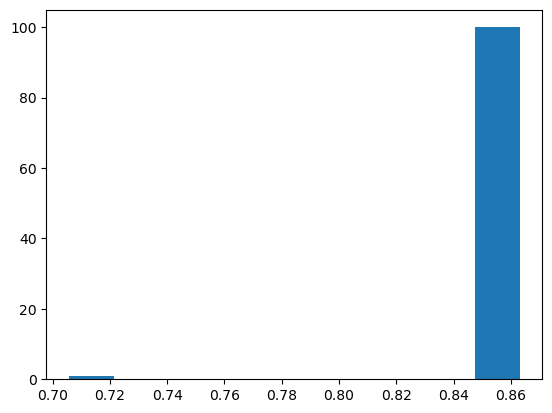

In [11]:
plt.hist(subj_01_param.V1)
plt.show()

## WILCOXON TEST 

In [5]:
T_values_df_W, p_values_df_W = wilcoxon_test(subj_list, rois)
T_values_df_W # check z values 

,V1,V2,V3,hV4,VO-1,VO-2,PHC-1,PHC-2,LO-1,LO-2,TO-1,TO-2
V1,0,1202.0,1419.0,1425.0,499.0,1537.0,1270.0,1594.0,1458.0,1478.0,1327.0,1398.0
V2,1202.0,0,1315.0,1232.0,601.0,975.0,929.0,1304.0,1468.0,1398.0,1521.0,944.0
V3,1419.0,1315.0,0,1525.0,559.0,1462.0,1270.0,1583.0,1458.0,1483.0,1325.0,1333.0
hV4,1425.0,1232.0,1525.0,0,1008.0,1289.0,1305.0,1608.0,1444.0,1420.0,1300.0,1424.0
VO-1,499.0,601.0,559.0,1008.0,0,1200.0,1068.0,1157.0,1010.0,1023.0,945.0,1261.0
VO-2,1537.0,975.0,1462.0,1289.0,1200.0,0,1426.0,1525.0,1303.0,1353.0,1237.0,1547.0
PHC-1,1270.0,929.0,1270.0,1305.0,1068.0,1426.0,0,1334.0,1079.0,1190.0,1064.0,1432.0
PHC-2,1594.0,1304.0,1583.0,1608.0,1157.0,1525.0,1334.0,0,1460.0,1339.0,914.0,1508.0
LO-1,1458.0,1468.0,1458.0,1444.0,1010.0,1303.0,1079.0,1460.0,0,1500.0,982.0,1208.0
LO-2,1478.0,1398.0,1483.0,1420.0,1023.0,1353.0,1190.0,1339.0,1500.0,0,789.0,1288.0


In [6]:
p_values_df_W

,V1,V2,V3,hV4,VO-1,VO-2,PHC-1,PHC-2,LO-1,LO-2,TO-1,TO-2
V1,1,0.044979,0.335019,0.349646,0.0,0.690562,0.09321,0.900758,0.43716,0.495825,0.159928,0.286977
V2,0.044979,1,0.143504,0.06275,0.000001,0.001977,0.000919,0.129614,0.46598,0.286977,0.634906,0.001186
V3,0.335019,0.143504,1,0.648644,0.0,0.448563,0.09321,0.859145,0.43716,0.511122,0.157096,0.168656
hV4,0.349646,0.06275,0.648644,1,0.003332,0.112383,0.130832,0.954103,0.398588,0.337429,0.12483,0.34718
VO-1,0.0,0.000001,0.0,0.003332,1,0.043963,0.008108,0.026373,0.003436,0.004191,0.001206,0.085094
VO-2,0.690562,0.001977,0.448563,0.112383,0.043963,1,0.352123,0.648644,0.128405,0.200331,0.066213,0.726242
PHC-1,0.09321,0.000919,0.09321,0.130832,0.008108,0.352123,1,0.170145,0.009465,0.039169,0.007659,0.367215
PHC-2,0.900758,0.129614,0.859145,0.954103,0.026373,0.648644,0.170145,1,0.44284,0.177737,0.000709,0.59114
LO-1,0.43716,0.46598,0.43716,0.398588,0.003436,0.128405,0.009465,0.44284,1,0.564916,0.002213,0.048147
LO-2,0.495825,0.286977,0.511122,0.337429,0.004191,0.200331,0.039169,0.177737,0.564916,1,0.000067,0.111302


In [11]:
arr1 = np.random.rand(80)
arr2 = np.random.rand(80)
res = stats.wilcoxon(arr1, arr2)
res.statistic  
# need to check how to interpret that 

1543.0

In [17]:
# apply rotation on one subject
def apply_rotation(target, subj, rois, sessions):
    # obtain the rotation matrix again
    rotations_df = create_rotation_df(subj, rois, sessions)
    rotations_df = rotations_df[rotations_df['base'] == target]
    indx_to_keep = rotations_df.groupby(['source', 'base'])['distance'].idxmin()
    rotations_df = rotations_df.loc[indx_to_keep]
    rotations_df = rotations_df.reset_index(drop=True)
    print(rotations_df.U)
    rotated_path = os.path.join(proj_dir, 'MDS_rotated', subj)
    print(rotated_path)
    if not os.path.exists(rotated_path):
        os.makedirs(rotated_path)
        print(os.path.exists(rotated_path))
    for roi in rois.keys():
        source_mds = np.load(f'/home/stan/thesis-repo/data/MDS/{subj}/{subj}_{sessions}_{roi}_mds_betas_train.npy', allow_pickle=False)
        mds_rotated_file = os.path.join(rotated_path, f'{subj}_{sessions}_{roi}_mds_betas_train_rotated_{target}.npy')
        # if the source is our reference point, just save it without applying rotation
        if roi == target:
            if not os.path.exists(mds_rotated_file):
                np.save(mds_rotated_file, source_mds, allow_pickle=True)
            continue 
        U = rotations_df.loc[rotations_df['source'] == roi, 'U'].squeeze()
        mds_rotated = np.dot(source_mds, U)  # apply rotation with dot product
        if not os.path.exists(mds_rotated_file):
            np.save(mds_rotated_file, mds_rotated, allow_pickle=True)
    
    

In [18]:
for i in range(1, 9):
    apply_rotation('PHC-1', f'subj0{i}', rois, sessions[i-1])


0     [[0.3854254, -0.9227389], [0.9227389, 0.3854254]]
1     [[-0.7893548309175643, -0.613937253232856], [0...
2     [[0.98475903, 0.17392436], [-0.17392436, 0.984...
3     [[0.86215484, -0.50664485], [0.50664485, 0.862...
4     [[-0.98772126, -0.15622663], [0.15622663, -0.9...
5     [[-0.6911771960423665, 0.7226853282522155], [-...
6     [[0.65729177, -0.75363624], [0.75363624, 0.657...
7     [[0.7329165, -0.6803186], [0.6803186, 0.7329165]]
8     [[0.13863223248103285, 0.9903439322363339], [-...
9     [[-0.6130681307201219, -0.7900300418941899], [...
10    [[-0.7989624207084763, -0.6013809527210279], [...
Name: U, dtype: object
/home/stan/thesis-repo/projects/NSD/MDS_rotated/subj01
0     [[-0.19842188, -0.9801167], [0.9801167, -0.198...
1     [[0.99857616, -0.053343683], [0.053343683, 0.9...
2     [[0.91326874, 0.40735754], [-0.40735754, 0.913...
3     [[0.9951258, 0.09861478], [-0.09861478, 0.9951...
4     [[-0.610746865004843, 0.7918259069307825], [-0...
5     [[-0.87343055, 0.486

In [19]:
# for all of rotated MDS: try to center them? Find the highest value from 0 